# Dependencies

In [1]:
!pip install -q numba
!pip install -q py_vollib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#from py_vollib.black_scholes.implied_volatility import implied_volatility

In [4]:
!git clone https://github.com/JustTheQuant/StochasticVolatilityTensorFlow.git

Cloning into 'StochasticVolatilityTensorFlow'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 29 (delta 9), reused 27 (delta 7), pack-reused 0
Receiving objects: 100% (29/29), 103.15 KiB | 4.69 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd StochasticVolatilityTensorFlow/SABRModel

/content/StochasticVolatilityTensorFlow/SABRModel


In [ ]:
from AsianPayoff import *

In [9]:
#Run for Tracing !
asian_skew(S0=100., r=0., maturity=0.5, sigma0=0.3, vega=0.1, rho=-0.2, strk=[100.], mcmSmpl=10000, nStps=80, call=1)

Tracing
Tracing
Tracing
Tracing


array([0.00850098], dtype=float32)

In [13]:
#Run for Tracing !
asian_price_mc_anthtc(S0=100., r=0., maturity=0.5, sigma0=0.3, vega=0.1, rho=-0.2, strk=[100.], mcmSmpl=10000, nStps=80, call=1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.850067], dtype=float32)>

# Example 1. Calculation of the Implied Volatility Skew

In [ ]:
maturity = 1/252 #
alpha = np.arange(0.1,0.8,0.05) #np.arange(0.1,1.5,0.1)
v=0.1
rho=-0.3
S0=100.

In [ ]:
# ATM Skew in Short maturity asymptotics
# Theoretical value is np.sqrt(3)*(6*v*rho + alpha)/30
skew = []
for i in alpha:
    skew.append(asian_skew(S0=S0, r=0., maturity=maturity, sigma0=i, vega=v, rho=rho, strk=[S0], mcmSmpl=2000000, nStps=80, call=1))
skew=np.array(skew).flatten()

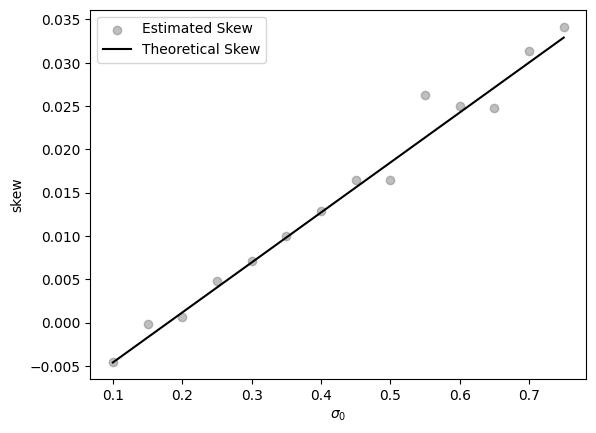

In [ ]:
# Scatter Plot
plt.figure()
plt.scatter(alpha, skew, color = 'grey', alpha=0.5,label='Estimated Skew') #plt.title("Skew of the ATM IV as a function of maturity")
plt.plot(alpha, np.sqrt(3)*(6*v*rho + np.array(alpha))/30, color = 'black', label='Theoretical Skew')
#plt.title("Thoretical vs Estimated ATM Skew")
plt.xlabel("$\sigma_0$")
plt.ylabel("skew")
plt.legend()
plt.show()

# Example 2. Approximation of the Asian Call Implied Volatility.

In [16]:
def asian_SABR_IV_proxy(S0, K, r, sigma0, v, rho, maturity, call):

    new_strike = tf.reshape( K, [-1,1])

    # Implied volatility approximation as a first order Taylor expansion around ATM strike.
    iv = sigma0/tf.math.sqrt(3.)+(tf.math.sqrt(3.)*rho*v/5+np.sqrt(3.)*sigma0/30.)*(tf.math.log( tf.constant( new_strike ) )-tf.math.log(S0))

    return iv.numpy().flatten()

In [10]:
maturity = [90/252, 180/252, 1.]
sigma0 = 0.4
v = 0.2
rho = -0.3
S0 = 100.
K = tf.constant(np.arange(90.,110.,1.),tf.float32 )

In [17]:
iv_proxy = []
iv = []
for date in maturity:
  price = asian_price_mc_anthtc(S0=S0, r=0., maturity=date, sigma0=sigma0, vega=v, rho=rho, strk=K, mcmSmpl=2000000, nStps=80, call=1)
  iv.append( iv_retr(S0=S0, opt_prices=np.array(price), strk=K, r=0., maturity=date, flag='c') )
  iv_proxy.append( asian_SABR_IV_proxy(S0=S0, K=K, r=0., sigma0=sigma0, v=v, rho=rho, maturity=date, call=1) )

In [ ]:
def small_plot(iv, iv_proxy, strike):

  plt.plot(strike, iv, color = 'k', alpha=0.5, label='T=1/252')
  plt.scatter(strike, iv_proxy, color = 'g', alpha=0.5, label='T=10/252')

  return

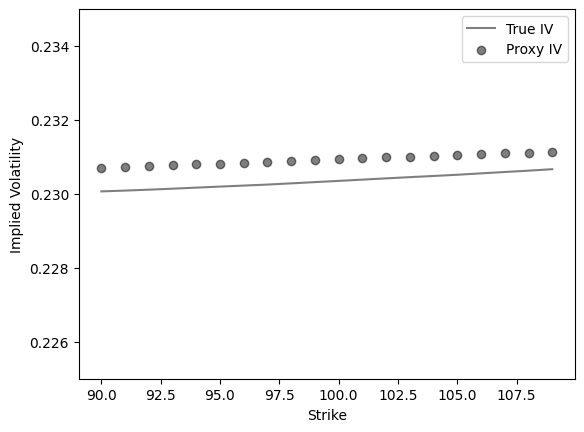

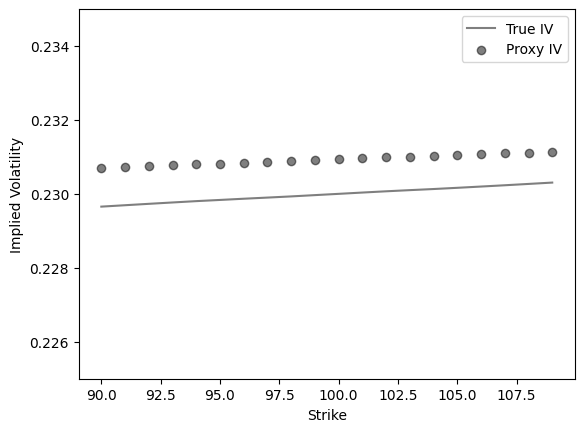

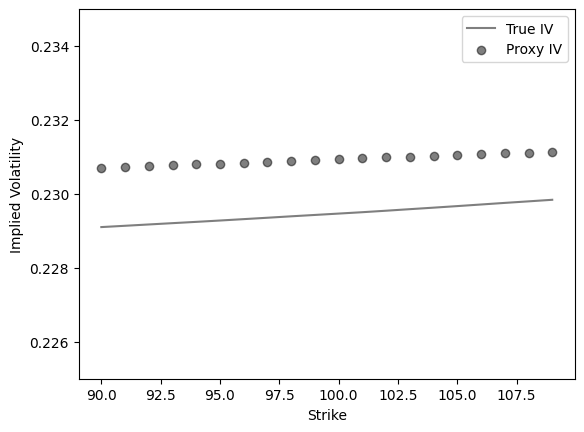

In [31]:
for date in range(len(maturity)):

  plt.plot(K, iv[date], color = 'k', alpha=0.5, label='True IV')
  plt.scatter(K, iv_proxy[date], color = 'black', alpha=0.5, label='Proxy IV')
  plt.xlabel("Strike")
  plt.ylabel("Implied Volatility")
  plt.legend()

  plt.ylim(0.225, 0.235)
  plt.show()